# Variograms

**Pending questions:**

- distribution of the variogram does not follow theoretical expectations


**To do:**

- different max lag
- different weighting for the fit ?

### general background

The variogram or semi-variance is given by:

$
\begin{align}
\gamma(\tau) &= \frac{1}{2} \big \langle [ u(t+\tau) - u(t) ]^2 \big \rangle, \\
&= \big \langle (u-\mu)^2 \big \rangle
- \big \langle [ u(t+\tau) - \mu] [u(t)-\mu] \big \rangle
\end{align}
$

where stationarity was assumed to derive the second equation and the mean of the process $\mu$ was introduced.
For large time lags, the variogram converges to the variable variance.
For an exponentially decaying autocovariance with timescale $T$, the variogram is thus given by:

$
\begin{align}
\gamma(\tau) &= \sigma_0 \Big ( 1 - e^{-t/T} \Big ),
\end{align}
$

where $\sigma_0$ is the variance of the signal.

Under normal assumption: 
$[u(t+\tau) - u(t)]^2 \sim 2\gamma(\tau) \chi_1^2$ 
where $\chi_1^2$ is the chi-squared random variable with 1 degree of freedom.

Fleming et al. 2014 (citing Cressie 1993) argues the variogram offers better estimators than the autocovariance and this motivates its use.

Estimates of the mean is circumvented in general while we may be interested in these.
These need to be estimated independantly.
The variogram helps estimate however the effective degrees of freedom which may be useful to provide confidence intervals for the mean and variance (if a non-parametric method such as bootstrap is not employed).

See Schabenberg section 4.5 (p163, p174) for a useful overview of the parametric modeling of variograms and a discussion of the merit of each approach.


### Estimations of the variogram

The **Matheron estimator** is the most popular estimator in geostatistics:

$
\begin{align}
\hat \gamma(\tau) = 
\frac{\sum_{t_i-t_j=\tau} |u(t_i) - u(t_j)|^2}{2N(\tau)}
\end{align}
$

where $N(\tau)$ is the number of pairs for lag $\tau$.
This estimate is the average of a variable that has mean $2\gamma(\tau)$ and variance ?? (?? under Gaussian assumption)

`np.correlate` may be used to output a quantity comparable to the Matheron estimator (see `autocorrelation_np.ipynb`).

You will find more estimators in skgstat.estimators. There is the Cressie-Hawkins, which is more robust to extreme values. Other so called robust estimators are Dowd or Genton. 

To account for "data with many large, irregular gaps", Fleming et al. 2014 derive a new weighted variogram estimator that is unbiased (see their appendix):

$
\begin{align}
\hat \gamma(\tau) = 
\frac{\sum_{t_i-t_j=\tau} w_{ij} |u(t_i)-u(t_j)|^2}{2\sum_{t_i-t_j=\tau} w_{ij}}
\end{align}
$

Note that such estimator could be useful for to process raw GDP data.

**Expected distribution of the estimate - confidence intervals ?**

### Fitting variograms to models

Appendix B of Fleming et al. 2014, fitting variograms involve weighted regressions.

The simplest unbiased weighted least squares (WLS) regression involves a number-weighted least squares cost function (Diggle and Ribeiro, 2007, Shabengerg refers to this estimate as the Ordinary Least Squares approach - OLS see p165):

$
\begin{align}
L_N(\theta | \hat \gamma) = \sum_{\tau>0} N(\tau) | \gamma(\tau|\theta) - \hat \gamma (\tau) |^2
\end{align}
$

The most commonly used WLS is given by (model) variogram weighting (Cressie, 1993, note that Shabengerg refers to this estimate as the Weighed Least Squares approach - WLS see p165):

$
\begin{align}
L_V (\theta | \hat \gamma) = 
\sum_{\tau>0} \frac{| \gamma(\tau|\theta) - \hat \gamma (\tau) |^2}{\gamma(\tau|\theta)^2 /N(\tau)}
\end{align}
$

(Note that ) \
Fleming et al. 2014 argues for a log-based cost function.

Schabenberg mentions also a generalized least square a 

### Comparing different variogram models

- visual inspection
- MSE
- AIC


SciKitGStat: "This is quite important. We find all 6 models to describe the experimental variogram more or less equally well in terms of MSE. Think of the implications: We basically can use any model we like. This is a problem as i.e. the gaussian and the spherical model describe fundamentally different spatial properties. Thus, our model selection should be driven by interpretation of the variogram, and not the difference in MSE of only 0.4%, which might very likely not be significant at all."

Fleming et al. 2014: "however, given the correlated nature of the variogram errors, AIC should not be used to select between qualitatively similar SVF models"



### Parameter uncertainties

Fleming is able to find some: bootstrap or statistical expectation?


### references:
- [Fleming et al. 2014](https://www.google.com/search?q=10.1111%2F2041-210X.12176): From Fine-Scale Foraging to Home Ranges: A Semivariance Approach to Identifying Movement Modes across Spatiotemporal Scales
- [Diggle and Ribeiro Model-based Geostatistics](...)
- [Schabenberg Statistical Methods for Spatial Data Analysis](...)

### illustration

Generate a 100 day time series with a 10 days decorrelation timescale

In [1]:
import xarray as xr
import numpy as np

from scipy.optimize import minimize
from scipy import stats                                                         
#from numpy.linalg import inv, slogdet
#from scipy.stats import chi2

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import skgstat as skg
from pprint import pprint

import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import models


/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#ts.exp_autocorr?

In [3]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale

delta_T = 100 # time series length
#delta_T = 300 # time series length
dt = 3/24 # sampling interval in days
Nw0 = 10 # number of windows averaged in the nominal case
Nw = [2, 5, 10, 20, 40]


# generate time series
u = mu + ts.exp_autocorr((delta_T, dt), T, 
                         np.sqrt(sigma0), 
                         #burnin=int(10*T/dt),
                         draws=1000, 
                         seed=0,
                        ).compute()

## derived parameters:
sigma_true = lambda tau: models["exp"]["sigma"](tau, sigma0, T)
gamma_true = lambda tau: models["exp"]["gamma"](tau, sigma0, T)

# total number of points
N = u.time.size # = delta_T/dt 

Compute the variogram:

In [4]:
ds = sigp.svariance(u, "time").rename("gamma_hat").to_dataset()
ds["gamma"] = ("lags", gamma_true(ds.lags.values))

In [5]:
def plot_gamma_stats(ds, title="variogram"):
    fig, ax = plt.subplots(1,1)

    ds["gamma_hat"].mean("draw").plot(label="mean")

    ds["gamma_hat"].quantile(0.05, "draw").plot(color="0.5", label="5%, 95%")
    ds["gamma_hat"].quantile(0.95, "draw").plot(color="0.5")

    ds["gamma"].plot(color="k", label="true")

    ax.legend()
    ax.grid()
    ax.set_title(title)

There is negative bias at large lags (lag>50days) which decreases when the length of the time series is increased.
See at the end of the notebook (section `with more sample points`).

But large lags (>50 days, or variogram larger than 3/4 of the signal variance) may be ignored in general.

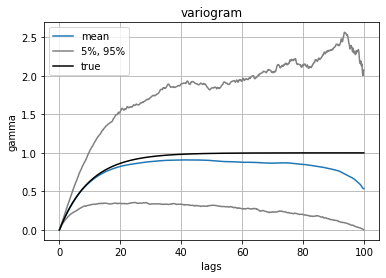

In [6]:
plot_gamma_stats(ds)

In [7]:
# averageds Nw0 (=10) independent autocorrelations together 
dsw = ds.coarsen(draw=Nw0).mean()

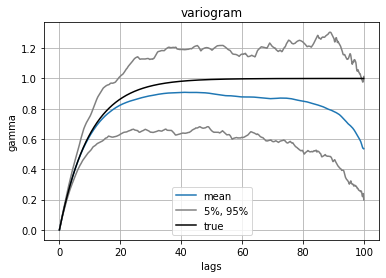

In [8]:
plot_gamma_stats(dsw)

### distribution

If the input time series is Gaussian, then:

$
\begin{align}
\frac{[u(t+\tau) - u(t)]^2/2}{\gamma(\tau)} &\sim \chi_1^2,
\end{align}
$

The variogram estimate is then an average over multiple $\chi_1^2$ distributed variables.
But these variables use common data points and are thus correlated.

If they were not correlated the distribution of the sum (i.e. $\hat \gamma(\tau) \times N(\tau) / \gamma(\tau)$) would be $\chi^2_{N(\tau)}$ where $N(\tau)$ is the number of points used in the estimation of the variogram at lag $\tau$. \
We'll refer to this as the naïve distribution.
This would lead to a variance of $2/N(\tau)$ which is close to Cressie 1985's approximation:

$
\begin{align}
Var[\hat \gamma (\tau)] \sim 2 \gamma(\tau)^2 / N(\tau)
\end{align}
$

The comparison between the naïve estimate of the distribution and the actual one indicates however that the naïve variance underestimate the actual one.

Reference: Schabenberg p 153

In [9]:
def show_dist(pdf, ax, 
              *args, 
              label="theoretical pdf", color="k", 
              **kwargs):
    #stats.norm.pdf, loc=mu, scale=sigma0/np.sqrt(Neff)
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = pdf(x_pdf, *args, **kwargs)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


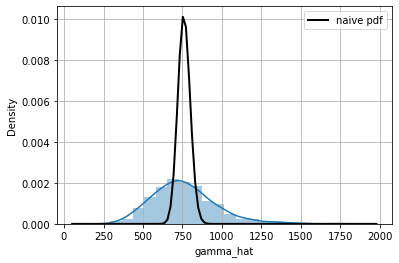

In [10]:
_lag = 5 # 5 days
_df = N - int(_lag/dt) # N(\tau)
_ds = ds.sel(lags=_lag)
_gamma = float(_ds.gamma)

ax = sns.distplot(_ds.gamma_hat/_gamma*_df, bins=20, norm_hist=True)
show_dist(stats.chi2.pdf, ax,
          _df,
          label="naive pdf", color="k", 
         )
ax.grid()
ax.legend()

## Autocorrelation model fit

In [28]:
def fit_model(ds, model, params, 
              method="n-weighted",
              lag_max=None,
              skip_lag0=True,
              nugget=False,
              **kwargs,
             ):
    """ Fit a variogram model to variogram estimates
    """

    variables = ["gamma_hat", "lags"]
    dim = "lags"
    lags_init = ds.lags
    
    if lag_max is None:
        lag_max = float(ds.lags.max())/2
    ds = ds.sel(lags=slice(0, lag_max), drop=True)
        
    if nugget or skip_lag0:
        ds = ds.where(ds.lags>0, drop=True)
    
    if method=="n-weighted":
        weights = (ds.N/ds.N.max()).values
    
    def J(x, gamma_hat, lags):
        return np.mean( (gamma_hat - model(lags, *x) )**2 * weights )

    dsm = sigp.minimize_xr(J, ds, params, variables, dim, **kwargs)
    
    # converts parameters (in x) into proper variables
    for v in params:
        dsm[v] = dsm.x.sel(parameters=v)
    dsm = dsm.drop("x")
    #
    dsm = dsm.rename(fun="MSE")
    dsm.attrs["method"] = method
    dsm.attrs["lag_max"] = lag_max

    gamma_fit = model(lags_init, *[dsm[v] for v in params])
    
    return dsm, gamma_fit

In [40]:
params=dict(sigma0=10, T=100)
dsm, ds["gamma_fit"] = fit_model(ds, models["exp"]["gamma"], params)

# with coarsened data
dsm_w, dsw["gamma_fit"] = fit_model(dsw, models["exp"]["gamma"], params)

In [41]:
def plot_svariance(truth, labels, *args, offset=0):

    fig, ax = plt.subplots(1,1)

    truth.plot(color="k", label="true")

    for i, ds in enumerate(args):
        ds.gamma_hat.plot(label="gamma_hat, "+labels[i], color=f"C{i+offset}")
        ds.gamma_fit.plot(label="fit, "+labels[i], color=f"C{i+offset}", ls="--")

    ax.grid()
    ax.legend()
    
    return fig, ax

### Visual comparison

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'draw = 4.5'}, xlabel='lags', ylabel='gamma_fit'>)

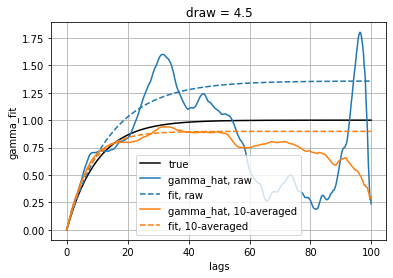

In [42]:
plot_svariance(ds.gamma, ["raw", f"{Nw0}-averaged"], 
               ds.isel(draw=0), dsw.isel(draw=0))

In [43]:
def plot_param(ds, param, truth, bins=None, ax=None, color=None):

    if ax is None:
        fig, ax = plt.subplots(1,1)

    ax.axvline(truth, color="k") # outliers !!

    ds[param].plot.hist(bins=bins, color=color, density=True, alpha=0.7)
    
    median = ds[param].median() # outliers !!
    ax.axvline(median, lw=3, color=color) 
    ax.axvline(median, ls="--", color="w")

    return ax

There are biases in variance and time scale estimates. \
These biases decrease with variogram averaging (up to some limit) and with time series length. \
This is explored more thoroughly below

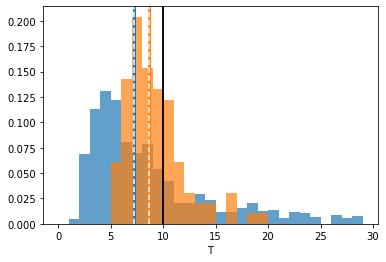

In [44]:
bins = np.arange(0,30)
ax = plot_param(dsm, "T", T, bins=bins, color="C0")
plot_param(dsm_w, "T", T, bins=bins, color="C1", ax=ax);

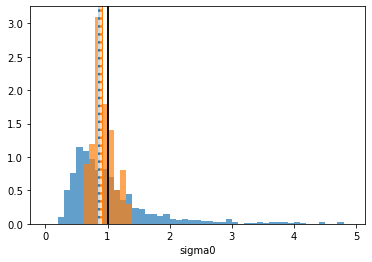

In [45]:
bins=np.arange(0,5,.1)
ax = plot_param(dsm, "sigma0", sigma0, bins=bins, color="C0")
plot_param(dsm_w, "sigma0", sigma0, bins=bins, color="C1", ax=ax);

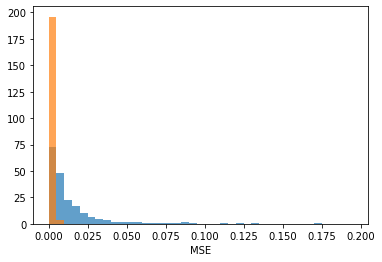

In [46]:
bins=np.arange(0,0.2,.005)
dsm["MSE"].plot.hist(bins=bins, density=True, alpha=0.7)
dsm_w["MSE"].plot.hist(bins=bins, density=True, alpha=0.7);

### more extensive inspection of sensitivity to averaging

Bias, variance, percentiles of parameters estimates.

There are biases in variance and time scale estimates. \
These biases decrease with variogram averaging (up to some limit) and with time series length. \

This limiting bias (for large amount of smoothing) decreases if the width of the time window is increased (`delta_T`). \
300 days induced biases smaller than 5% approximately for example (see bottom of the notebook).

In [47]:
def process_average(ds, Nw, model, params, alpha=0.05):
    """ coarsen data and compute estimator statistics
    """

    ds = ds.coarsen(draw=Nw).mean()
    
    dsm, _ = fit_model(ds, model, params)
    
    # mean
    mean = xr.merge([dsm[p].mean().rename(p+"_mean") for p in params])
    # median
    median = xr.merge([dsm[p].median().rename(p+"_median") for p in params])
    # variance
    var = xr.merge([dsm[p].var().rename(p+"_var") for p in params])
    # quantiles
    quantiles = xr.merge([dsm[p].quantile([alpha, 1-alpha]).rename(p+"_q") for p in params])    
    
    ds_out = xr.merge([mean, median, var, quantiles])
        
    return ds_out

In [48]:
ds_Nw = xr.concat([process_average(ds, n, models["exp"]["gamma"], params) for n in Nw], 
                  dim=xr.DataArray(Nw, name="Nw", dims="Nw"))

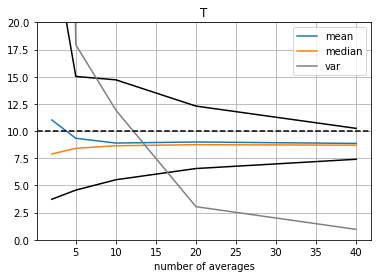

In [49]:
p = "T"
truth = T

fig, ax = plt.subplots(1,1)
ds_Nw[p+"_mean"].plot(label="mean")
ds_Nw[p+"_median"].plot(label="median")
ds_Nw[p+"_q"].plot.line(x="Nw", color="k", add_legend=False)
ds_Nw[p+"_var"].plot(color="0.5", label="var")

ax.axhline(T, color="k", ls="--")
ax.grid()
ax.set_ylim(0,2*truth)
ax.set_title(p)
ax.set_xlabel("number of averages")
ax.set_ylabel("")
ax.legend()

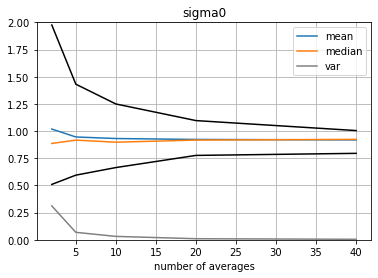

In [50]:
p = "sigma0"
truth = sigma0

fig, ax = plt.subplots(1,1)
ds_Nw[p+"_mean"].plot(label="mean")
ds_Nw[p+"_median"].plot(label="median")
ds_Nw[p+"_q"].plot.line(x="Nw", color="k", add_legend=False)
ds_Nw[p+"_var"].plot(color="0.5", label="var")

ax.axhline(T, color="k", ls="--")
ax.grid()
ax.set_ylim(0,2*truth)
ax.set_title(p)
ax.set_xlabel("number of averages")
ax.set_ylabel("")
ax.legend()

## compare exponential fit with gaussian and Matern fit

We consider the smoothed varigram (10 member average) from now on

In [51]:
dsm_gaussian, gamma_gaussian = fit_model(dsw, models["gaussian"]["gamma"], params)

In [52]:
dsm_matern, gamma_matern = fit_model(dsw, 
                                     models["matern"]["gamma"], 
                                     models["matern"]["params"],
                                     bounds=[[1e-6, None], [1e-6, None], [1e-6, 10]],
                                    )

### Visual comparison

(0.0, 40.0)

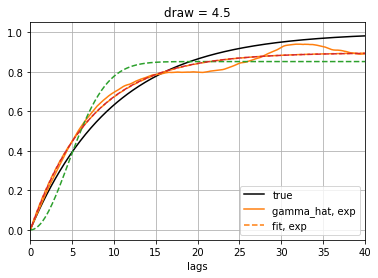

In [53]:
i = 0
fig, ax = plot_svariance(ds.gamma, ["exp"], 
                         dsw.isel(draw=i), offset=1)

gamma_gaussian.isel(draw=i).plot(label="fit, gaussian", color="C2", ls="--")
gamma_matern.isel(draw=i).plot(label="fit, matern", color="C3", ls="--")

ax.set_xlim(0,T*4)

**exponential vs gaussian**

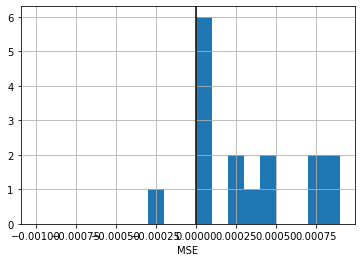

In [54]:
fig, ax = plt.subplots(1,1)
dMSE = dsm_gaussian.MSE - dsm_w.MSE
delta = 1e-3
dMSE.plot.hist(bins=np.arange(-delta,delta,delta/10));
ax.axvline(0, color="k")
ax.grid()

In [56]:
def get_success(delta):
    """ count fraction of time delta is positive
    """
    count = float(xr.where(delta>0, 1, 0).sum("draw"))
    return count/delta.draw.size

success = get_success(dMSE)
print(f"Success probability is {success*1e2:.1f}%")

Success probability is 98.0%


**exponential vs Matern**

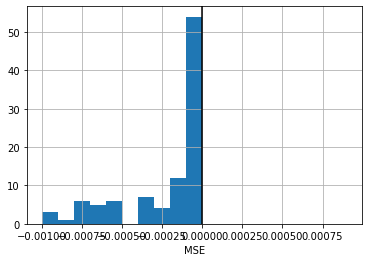

In [58]:
fig, ax = plt.subplots(1,1)
dMSE = dsm_matern.MSE - dsm_w.MSE
delta = 1e-3
dMSE.plot.hist(bins=np.arange(-delta,delta,delta/10));
ax.axvline(0, color="k")
ax.grid()

Recall Matern shape parameter $\kappa$:

- 0.5: exponential
- inf: gaussian

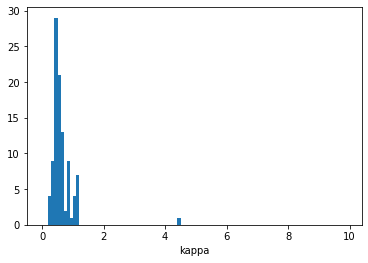

In [59]:
dsm_matern.kappa.plot.hist(bins=np.arange(0,10,.1));

### Loop over different number of averages

In [62]:
def process_average_model(ds, Nw, models, alpha=0.05):
    """ coarsen data and compute estimator statistics
    """

    ds = ds.coarsen(draw=Nw).mean()
    
    labels=list(models)
    
    dsm = {}
    for label, m in models.items():
        if label=="matern":
            _kwargs = dict(bounds=[[1e-6, None], [1e-6, None], [1e-6, 10]],)
        else:
            _kwargs = {}
        _dsm, _ = fit_model(ds, m["gamma"], m["params"], **_kwargs)
        dsm[label] = _dsm

    # compare models MSE with first one: mse
    ds = xr.concat([(_dsm.MSE - dsm[labels[0]].MSE).rename("delta_mse")
                    for label, _dsm in dsm.items()
                   ],
                   dim=xr.DataArray(labels, name="model", dims="model"),
                  ).to_dataset()
    for v in ["sigma0", "T"]:
        ds[v] = xr.concat([_dsm[v] for label, _dsm in dsm.items()], dim="model")
    
    if "matern" in models:
        ds["matern_kappa"] = dsm["matern"].kappa
    
    return ds

In [63]:
d_md = {n: process_average_model(ds, n, models) for n in Nw}

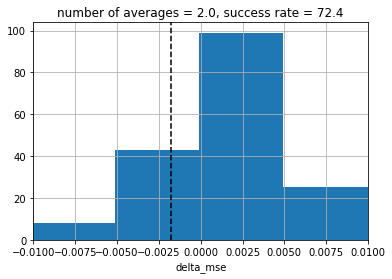

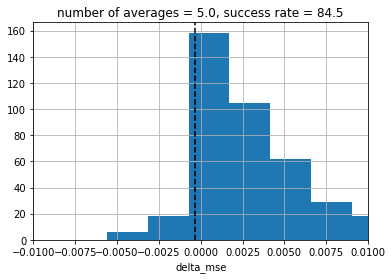

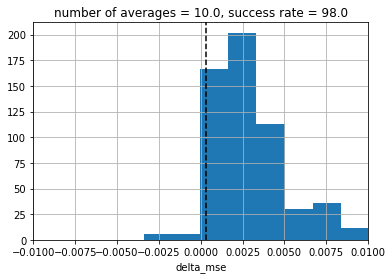

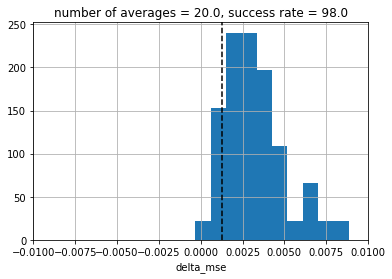

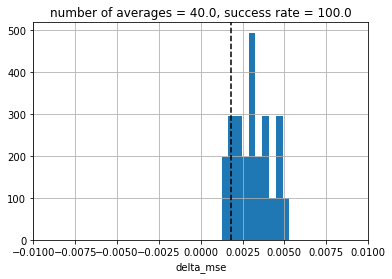

In [64]:
alpha = 0.9

for n, _d in d_md.items():
    
    fig, ax = plt.subplots(1,1)
    
    _da = _d["delta_mse"].sel(model="gaussian")
    _da.plot.hist(density=True, label="{}".format(float(n)) )  #alpha=0.5,)
    _qt = _da.quantile([1-alpha])
    ax.axvline(float(_qt), ls="--", color="k")
    
    #ax.legend()
    ax.grid()
    ax.set_xlim(-1e-2,1e-2)
    
    success = get_success(_da)
    
    ax.set_title(f"number of averages = {float(n)}, success rate = {success*1e2:.1f}")

The success rate is also a function of the length of the time window (`delta_T`). \
For only 2 averages, the success rate with 300 days window is about 85% for example against 62% for 100 days.

### Parameters and matern shape parameter

All model fits are able to capture the variance of the signal.
The matern timescale exhibits more variability. \
Does the shape parameter converges towards the right value?
Answer is yes. \
Shape parameter $\kappa$ and length scale may become correlated (illustrated below).


In [65]:
def plot_parameter(d_md, v, xlims=None, alpha=0.9):

    
    if xlims is not None:
        bins = np.linspace(xlims[0], xlims[1], 30)
    else:
        bins = None
    
    for n, _d in d_md.items():

        fig, ax = plt.subplots(1,1)
        
        for m in _d.model:
            _da = _d.sel(model=m)[v]
            _da.plot.hist(bins=bins,
                          density=True, 
                          label="{}".format(str(m.values)),
                         alpha=0.5)
            #_qt = _da.quantile([alpha/2, 1-alpha/2])
            #ax.axvline(_qt, ls="--", color="k")
        #ax.axvline(0.5, ls="--", color="k")

        ax.legend()
        ax.grid()
        if xlims is not None:
            ax.set_xlim(xlims)

        ax.set_title(f"{v}, number of averages = {float(n)}")


#### Variance

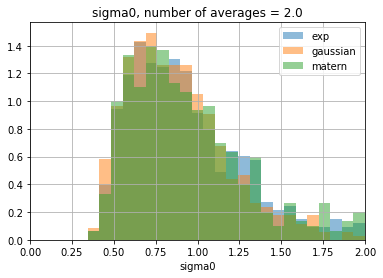

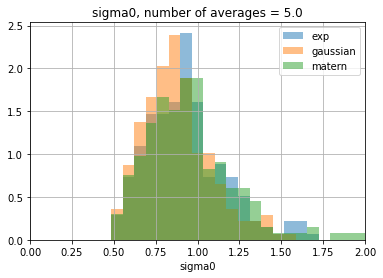

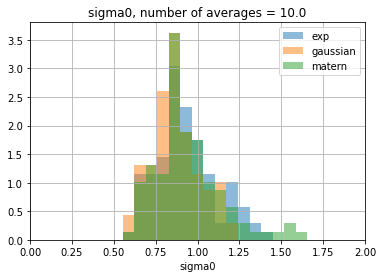

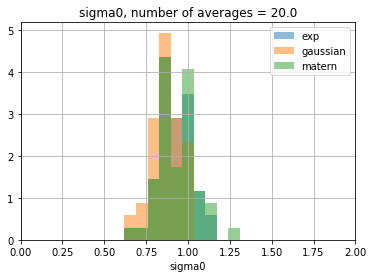

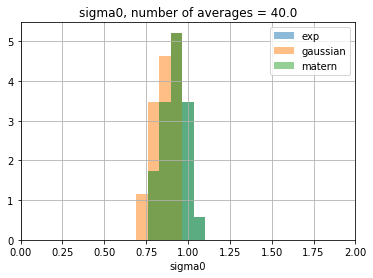

In [66]:
plot_parameter(d_md, "sigma0", xlims=(0,2))

#### decay timescale

Matern exhibits more variability and this is likely to the timescale - kappa interplay

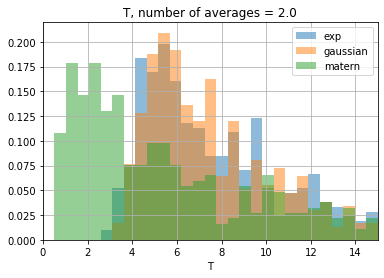

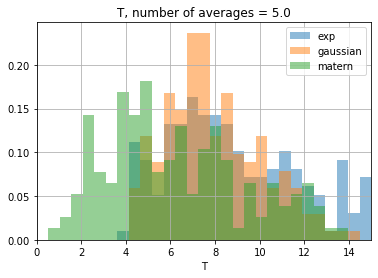

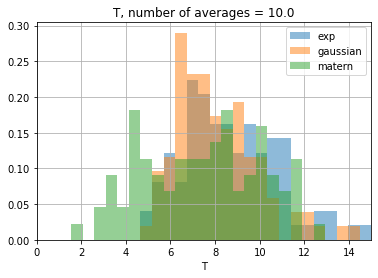

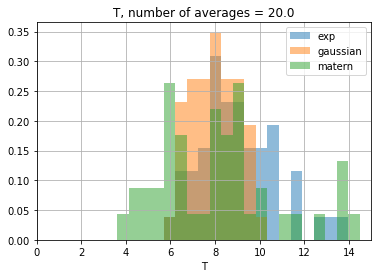

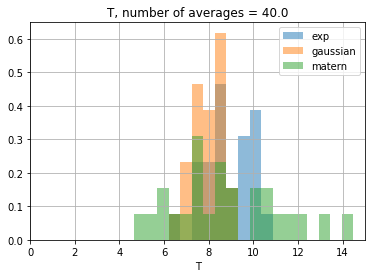

In [67]:
plot_parameter(d_md, "T", xlims=(0,15))

#### Convergence of the kappa parameter for the matern fit:

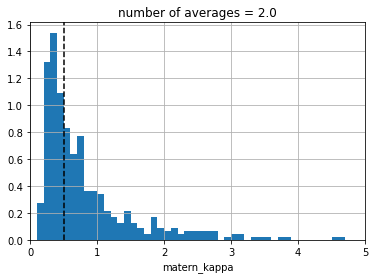

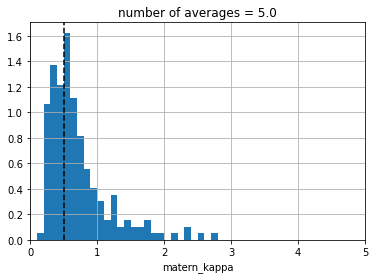

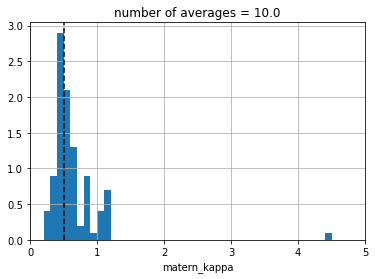

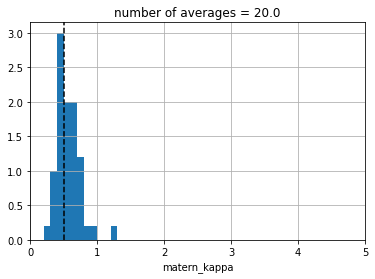

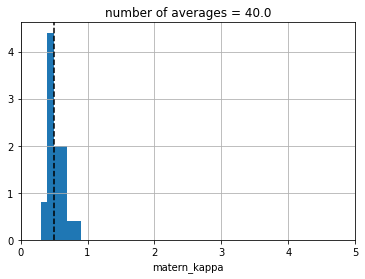

In [68]:
for n, _d in d_md.items():
    
    fig, ax = plt.subplots(1,1)
    
    _da = _d.matern_kappa
    _da.plot.hist(bins=np.arange(0,10,.1),
                  density=True, label="{}".format(float(n)) )
    #_qt = _da.quantile([1-alpha])
    #ax.axvline(float(_qt), ls="--", color="k")
    ax.axvline(0.5, ls="--", color="k")
    
    #ax.legend()
    ax.grid()
    ax.set_xlim(0, 5)
        
    ax.set_title(f"number of averages = {float(n)}")

#### Show the temporal scale - kappa correlation for the matern fit:

Text(0, 0.5, 'kappa [1]')

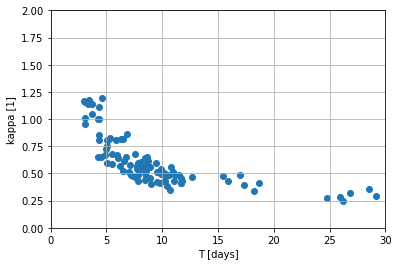

In [69]:
fig, ax = plt.subplots(1,1)
ax.scatter(d_md[10].T.sel(model="matern"), d_md[10].matern_kappa)
ax.set_xlim(0,30)
ax.set_ylim(0,2)
ax.grid()
ax.set_xlabel("T [days]")
ax.set_ylabel("kappa [1]")

---

## sensitivity to maximum lag

When fitting variograms, using all lags (orange) vs half of them (blue, default) does not affect 

In [72]:
params=dict(sigma0=10, T=10)
dsm_full, _ = fit_model(ds, models["exp"]["gamma"], params, lag_max=2*delta_T)

# with coarsened data
dsm_w_full, _ = fit_model(dsw, models["exp"]["gamma"], params, lag_max=2*delta_T)

Raw variograms

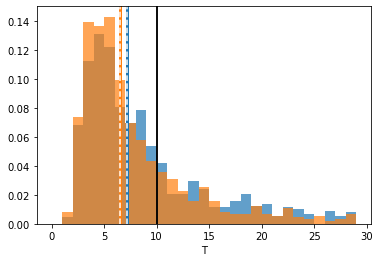

In [74]:
bins = np.arange(0,30)
ax = plot_param(dsm, "T", T, bins=bins, color="C0")
plot_param(dsm_full, "T", T, bins=bins, color="C1", ax=ax);

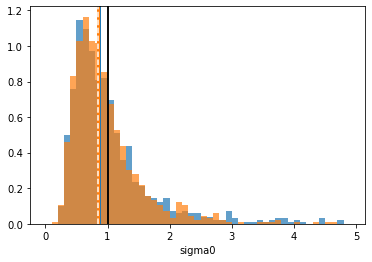

In [82]:
bins = np.arange(0,5,.1)
ax = plot_param(dsm, "sigma0", sigma0, bins=bins, color="C0")
plot_param(dsm_full, "sigma0", sigma0, bins=bins, color="C1", ax=ax);

Smoothed variograms

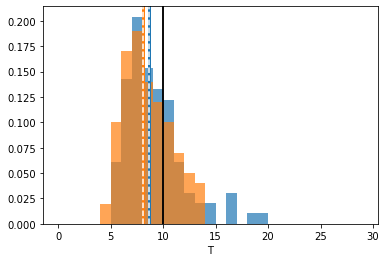

In [79]:
bins = np.arange(0,30)
ax = plot_param(dsm_w, "T", T, bins=bins, color="C0")
plot_param(dsm_w_full, "T", T, bins=bins, color="C1", ax=ax);

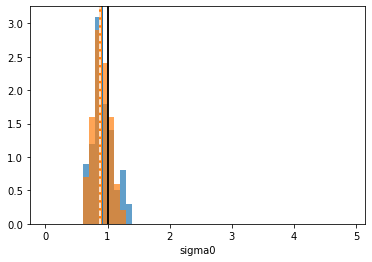

In [81]:
bins = np.arange(0,5,.1)
ax = plot_param(dsm_w, "sigma0", sigma0, bins=bins, color="C0")
plot_param(dsm_w_full, "sigma0", sigma0, bins=bins, color="C1", ax=ax);

---

## with more sample points

Biases on variance and the decay time scales are indeed reduced.

In [83]:
delta_T = 300 # time series length
dt = 3/24 # sampling interval in days

# generate time series
u = mu + ts.exp_autocorr((delta_T, dt), T, 
                         np.sqrt(sigma0), 
                         #burnin=int(10*T/dt),
                         draws=1000, 
                         seed=0,
                        ).compute()

# total number of points
N = u.time.size # = delta_T/dt 

In [84]:
ds = sigp.svariance(u, "time").rename("gamma_hat").to_dataset()
ds["gamma"] = ("lags", gamma_true(ds.lags.values))
dsw = ds.coarsen(draw=Nw0).mean()

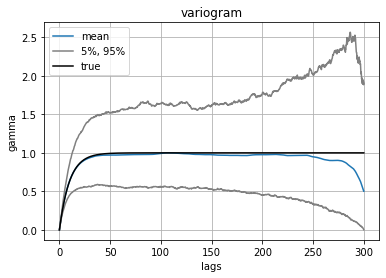

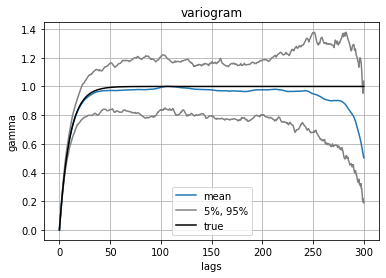

In [85]:
plot_gamma_stats(ds)
plot_gamma_stats(dsw);

In [86]:
params=dict(sigma0=10, T=1)
dsm, ds["gamma_fit"] = fit_model(ds, models["exp"]["gamma"], params,)

# with coarsened data
dsm_w, dsw["gamma_fit"] = fit_model(dsw, models["exp"]["gamma"], params,)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'draw = 4.5'}, xlabel='lags', ylabel='gamma_fit'>)

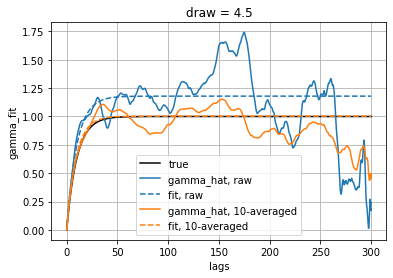

In [87]:
plot_svariance(ds.gamma, ["raw", f"{Nw0}-averaged"], 
               ds.isel(draw=0), dsw.isel(draw=0))

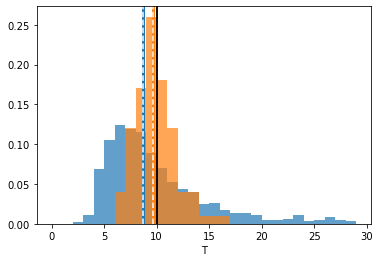

In [88]:
bins = np.arange(0,30)
ax = plot_param(dsm, "T", T, bins=bins, color="C0")
plot_param(dsm_w, "T", T, bins=bins, color="C1", ax=ax);

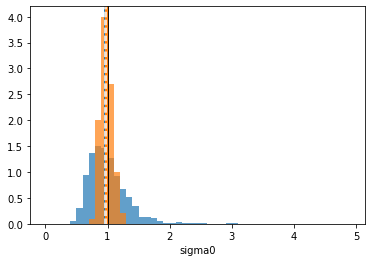

In [89]:
bins=np.arange(0,5,.1)
ax = plot_param(dsm, "sigma0", sigma0, bins=bins, color="C0")
plot_param(dsm_w, "sigma0", sigma0, bins=bins, color="C1", ax=ax);